# Llama1 

Llama is the transformer-baed model for language modeling. 

Ref: https://github.com/facebookresearch/llama

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
import time
import pandas as pd

## Setup dataset

We use TinyShakespeare dataset for training.
This data is about 1M characters long and is a subset of the Shakespeare dataset.

In [2]:
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])

print('vocab size:', len(vocab))
decode(encode("hello"))

vocab size: 65


'hello'

In [4]:
# Configrations
MASTER_CONFIG = {
    "vocab_size": len(vocab),
}

In [6]:
# Load data into memory
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [7]:
# Data Generator
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]
    
    batch_data = train
    if split == 'val':
        batch_data = val

    if split == 'test':
        batch_data = test
    
    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

MASTER_CONFIG.update({
    'batch_size': 8,
    'context_window': 16
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[("\nAnd 'twere the ", "And 'twere the c"),
 ('EO:\nWhat, shall ', 'O:\nWhat, shall I'),
 ('prove myself a l', 'rove myself a lo'),
 ('n my life, and h', ' my life, and ho'),
 ('ture, letting it', 'ure, letting it '),
 (' female buds sha', 'female buds shal'),
 ('s he is but my f', ' he is but my fa'),
 (' funeral;\nOur in', 'funeral;\nOur ins')]

I love the idea from [here](https://github.com/bkitano/llama-from-scratch/blob/main/llama.ipynb). 

What's interesting about implementing papers is that there are two aspects to the model working: compilation (do your tensors all match up from layer to layer), and training (does the loss go down). Figuring out how to ensure that each of your compoenents is working is key to developing your model in a predictable, engineering-minded way.

That's why we're also going to define the method for how we're going to evaluate the model. We want to do this before we even define the model, because we want to be able to use it to evaluate the model as we're training it.


In [8]:
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])    
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    return out

# Baseline Model

Before we start implementing the very complex model like Llama, we need to have a baseline model to start with, and then swap out parts of it as we go along until we eventually end up with the model as described in the paper Llama.



In [9]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__() 
        self.config = config 
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size'])
        )

        print("Total number of parameters:", sum(p.numel() for p in self.parameters()))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        logits = F.log_softmax(a, dim=-1)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        else:
            return logits
        
MASTER_CONFIG.update({
    'd_model': 128
})

model = SimpleBrokenModel(MASTER_CONFIG)
xs, xy = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = model(xs, xy)

Total number of parameters: 33217


Let's train the `SimpleBrokenModel` to make sure gradient descent is working.After confirming that, we can swap out parts of it to match Llama's architecture. Then, train the model again and track the progress of the loss.

Total number of parameters: 33217
Epoch: 0, Train loss: 4.143358945846558, Val loss: 4.139776515960693, Time: 0.00
Epoch: 10, Train loss: 3.626010608673096, Val loss: 3.6305429697036744, Time: 0.02
Epoch: 20, Train loss: 3.2050559759140014, Val loss: 3.2369032859802247, Time: 0.02
Epoch: 30, Train loss: 2.9839334964752195, Val loss: 2.9880322933197023, Time: 0.01
Epoch: 40, Train loss: 2.8230687856674193, Val loss: 2.8389495611190796, Time: 0.01
Epoch: 50, Train loss: 2.7207280158996583, Val loss: 2.743194818496704, Time: 0.01
Epoch: 60, Train loss: 2.7251606225967406, Val loss: 2.736199164390564, Time: 0.01
Epoch: 70, Train loss: 2.6368897438049315, Val loss: 2.6773905992507934, Time: 0.01
Epoch: 80, Train loss: 2.6466504335403442, Val loss: 2.612106776237488, Time: 0.01
Epoch: 90, Train loss: 2.653713917732239, Val loss: 2.669803285598755, Time: 0.01
Epoch: 100, Train loss: 2.6079373598098754, Val loss: 2.6559552192687987, Time: 0.01
Epoch: 110, Train loss: 2.5932779788970945, Val lo

<Axes: >

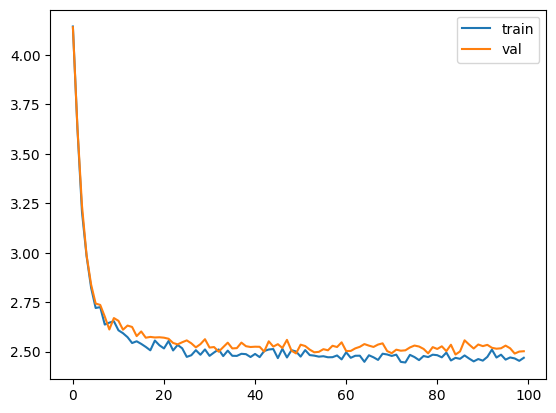

In [13]:
MASTER_CONFIG.update({
    'lr': 1e-3,
    'n_epochs': 1000, 
    'print_every': 10, 
    'batch_size': 32
})

model = SimpleBrokenModel(MASTER_CONFIG)

optimizer = torch.optim.Adam(model.parameters(), lr=MASTER_CONFIG['lr'])

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, verbose=True):
    losses = []
    start_time = time.time()

    for epoch in range(config['n_epochs']):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        logits, loss = model(xs, ys)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        if epoch % config['print_every'] == 0:
            batch_time = time.time() - start_time
            eval_loss = evaluate_loss(model)
            losses.append(eval_loss)
            if verbose:
                if scheduler is not None:
                    print(f"Epoch: {epoch}, Train loss: {eval_loss['train']}, Val loss: {eval_loss['val']}, Time: {batch_time:.2f}, LR: {scheduler.get_last_lr()[0]}")
                else:
                    print(f"Epoch: {epoch}, Train loss: {eval_loss['train']}, Val loss: {eval_loss['val']}, Time: {batch_time:.2f}")
            start_time = time.time()
    print("Validation loss:", losses[-1]['val'])
    return pd.DataFrame(losses).plot()
    
train(model, optimizer)